# Misspecification Tests for Log-Normal and Over-Dispersed Poisson Chain-Ladder Models

We replicate the empirical applications in [Harnau (2018)](http://mdpi.com/2227-9091/6/2/25) in Section 5.

*The work on this vignette was supported by the European Research Council, grant AdG 694262.*

First, we import the package

In [1]:
import apc

In [2]:
# Turn off future warnings
import warnings
warnings.simplefilter('ignore', FutureWarning)

## 5.1 Log-Normal Chain-Ladder

This corresponds to Section 5.1 in the paper. The data are taken from Verrall et al. (2010). Kuang et al. (2015) fitted a log-normal chain-ladder model to this data. The model is given by
$$ M^{LN}_{\mu, \sigma^2}: \quad \log(Y_{ij}) \stackrel{D}{=} N(\alpha_i + \beta_j + \delta, \sigma^2). $$
They found that the largest residuals could be found within the first five accident years. Consequently, they raised the question whether the model is misspecified. Here, we investigate this question.

### Full model

We set up and estimate the full, most restrictive, model $M^{LN}_{\mu, \sigma^2}$.

We begin by setting up a model class.

In [3]:
model_VNJ = apc.Model()

Next, we attach the data for the model. The data come pre-formatted in the package.

In [4]:
model_VNJ.data_from_df(apc.loss_VNJ(), data_format='CL')

We fit a log-normal chain-ladder model to the full data.

In [5]:
model_VNJ.fit('log_normal_response', 'AC')

and confirm that we get the same result as in the paper for the log-data variance estimate $\hat{\sigma}^{2,LN}$ and the degrees of freedom $df$. This should correspond to the values for $\mathcal{I}$ in Figure 2(b).

In [6]:
print('log-data variance full model: {:.3f}'.format(model_VNJ.s2))
print('degrees of freedom full model: {:.0f}'.format(model_VNJ.df_resid))

log-data variance full model: 0.075
degrees of freedom full model: 36


This matches the results in the paper.

### Sub-models

We move on to split the data into sub-samples. The sub-samples $\mathcal{I}_1$ and $\mathcal{I}_2$ contain the first and the last five accident years, respectively. Accident years correspond to "cohorts" in age-period-cohort terminology. Rather than first splitting the sample and the generating a new model and fitting it, we make use of the "sub_model" functionality of the package which does all that for us. Combined, the sub-models correspond to $M^{LN}$.

In [7]:
sub_model_VNJ_1 = model_VNJ.sub_model(coh_from_to=(1,5), fit=True)
sub_model_VNJ_2 = model_VNJ.sub_model(coh_from_to=(6,10), fit=True)

We can check that this generated the estimates $\hat{\sigma}^{2, LN}_\ell$ and degrees of freedom $df_\ell$ from the paper.

In [8]:
print('First five accident years (I_1)')
print('-------------------------------')
print('log-data variance: {:.3f}'.format(sub_model_VNJ_1.s2))
print('degrees of freedom: {:.0f}\n'.format(sub_model_VNJ_1.df_resid))

print('Last five accident years (I_2)')
print('------------------------------')
print('log-data variance: {:.3f}'.format(sub_model_VNJ_2.s2))
print('degrees of freedom: {:.0f}'.format(sub_model_VNJ_2.df_resid))

First five accident years (I_1)
-------------------------------
log-data variance: 0.095
degrees of freedom: 26

Last five accident years (I_2)
------------------------------
log-data variance: 0.027
degrees of freedom: 6


Reassuringly, it does. We can then also compute the weighted average predictor $\bar{\sigma}^{2,LN}$

In [9]:
s2_bar_VNJ = ((sub_model_VNJ_1.s2 * sub_model_VNJ_1.df_resid 
              + sub_model_VNJ_2.s2 * sub_model_VNJ_2.df_resid)
              /(sub_model_VNJ_1.df_resid + sub_model_VNJ_2.df_resid))
print('Weighted avg of log-data variance: {:.3f}'.format(s2_bar_VNJ))

Weighted avg of log-data variance: 0.082


Check!

### Testing for common variances

Now we can move on to test the hypothesis of common variances
$$ H_{\sigma^2}: \sigma^2_1 = \sigma^2_2. $$
This corresponds to testing for a reduction from $M^{LN}$ to $M^{LN}_{\sigma^2}$.

First, we can conduct a Bartlett test. This functionality is pre-implemented in the package.

In [10]:
bartlett_VNJ = apc.bartlett_test([sub_model_VNJ_1, sub_model_VNJ_2])

The test statistic $B^{LN}$ is computed as the ratio of $LR^{LN}$ to the Bartlett correction factor $C$. The p-value is computed by the $\chi^2$ approximation to the distribution of $B^{LN}$. The number of sub-samples is given by $m$.

In [11]:
for key, value in bartlett_VNJ.items():
    print('{}: {:.2f}'.format(key, value))

B: 2.79
LR: 2.96
C: 1.06
m: 2.00
p_value: 0.09


We get the same results as in the paper. Specifically, we get a p-value of $0.09$ for the hypothesis so that the Bartlett test does not arm us with strong evidence against the null hypothesis.

In the paper, we also conduct an $F$-test for the same hypothesis. The statistic is computed as
$$ F_{\sigma^2}^{LN} = \frac{\hat\sigma^{2,LN}_2}{\hat\sigma^{2,LN}_1} $$
which, under the null, is distributed as $\mathrm{F}_{df_2, df_1}$. This is not directly implemented in the package but still easily computed. 

First we compute the test statistic

In [12]:
F_VNJ_sigma2 = sub_model_VNJ_2.s2/sub_model_VNJ_1.s2
print('F statistic for common variances: {:.2f}'.format(F_VNJ_sigma2))

F statistic for common variances: 0.28


Now we can compute p-values in one-sided and two-sided tests. 
For an (equal-tailed) two-sided test, we first find the percentile $P(F_{\sigma^2}^{LN} \leq \mathrm{F}_{df_2, df_1})$. This is given by

In [13]:
from scipy import stats
F_VNJ_sigma2_percentile = stats.f.cdf(
    F_VNJ_sigma2, dfn=sub_model_VNJ_2.df_resid, dfd=sub_model_VNJ_1.df_resid
)
print('Percentile of F statistic: {:.2f}'.format(F_VNJ_sigma2_percentile))

Percentile of F statistic: 0.06


If this is below the 50th percentile, the p-value is simply twice the percentile, otherwise we subtract the percentile from unity and multiply that by two. For intuition, we can look at the plot below. The green areas in the lower and upper tail of the distribution contain the same probability mass, namely $P(F_{\sigma^2}^{LN} \leq \mathrm{F}_{df_2, df_1})$. The two-sided p-value corresponds to the sum of the two areas.

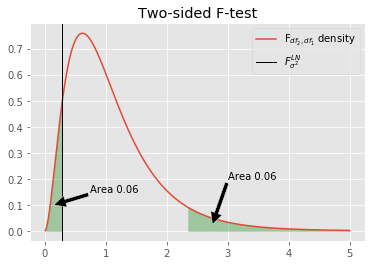

In [14]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x = np.linspace(0.01,5,1000)
y = stats.f.pdf(x, 
            dfn=sub_model_VNJ_2.df_resid, 
            dfd=sub_model_VNJ_1.df_resid)
plt.figure()
plt.plot(x, y, label='$\mathrm{F}_{df_2, df_1}$ density')

plt.axvline(F_VNJ_sigma2, color='black', linewidth=1, label='$F^{LN}_{\sigma^2}$')
tmp = stats.f.cdf(F_VNJ_sigma2, 
                  dfn=sub_model_VNJ_2.df_resid, 
                  dfd=sub_model_VNJ_1.df_resid)
plt.fill_between(x[x < F_VNJ_sigma2], y[x < F_VNJ_sigma2], color='green', alpha=0.3)
tmp = stats.f.ppf(1-tmp,
                  dfn=sub_model_VNJ_2.df_resid, 
                  dfd=sub_model_VNJ_1.df_resid)
plt.fill_between(x[x > tmp], y[x > tmp], color='green', alpha=0.3)
plt.annotate('Area 0.06', xy=(0.15, 0.1), 
             xytext=(0.75, 0.15), arrowprops=dict(facecolor='black'))
plt.annotate('Area 0.06', xy=(2.75, 0.025), 
             xytext=(3, 0.2), arrowprops=dict(facecolor='black'))
plt.legend()
plt.title('Two-sided F-test')
plt.show()

Since $F_{\sigma^2}^{LN}$ is below the 50th percentile, the two-sided equal tailed p-value is in our case given by

In [15]:
print('F test two-sided p-value: {:.2f}'.format(
    2*np.min([F_VNJ_sigma2_percentile, 1-F_VNJ_sigma2_percentile])
)
     )

F test two-sided p-value: 0.12


The one-sided p-value for the hypothesis $H_{\sigma^2}: \sigma^2_1 \leq \sigma^2_2$ simply corresponds to the area in the lower tail of the distribution. This is because the statistic is $\hat\sigma^{2,LN}_2/\hat\sigma^{2,LN}_1$ so that smaller values work against our hypothesis. Thus, the rejection region is the lower tail.

*Remark: in the paper, the one-sided hypothesis is given as $H_{\sigma^2}: \sigma^2_1 > \sigma^2_2$. This is a mistake as this  corresponds to the alternative.*

In [16]:
print('F statistic one-sided p-value: {:.2f}'.format(F_VNJ_sigma2_percentile))

F statistic one-sided p-value: 0.06


### Testing for common linear predictors

We can move on to test for common linear predictors:
$$ H_{\mu, \sigma^2}: \sigma^2_1 = \sigma^2_2 \quad \text{and} \quad \alpha_{i,\ell} + \beta_{j,\ell} + \delta_\ell = \alpha_i + \beta_j + \delta $$
If we are happy to accept the hypothesis of common variances $H_{\sigma^2}: \sigma^2_1 = \sigma^2_2$, we can test $H_{\mu, \sigma^2}: \sigma^2_1$ with a simple $F$-test; corresponding to a reduction from $M^{LN}_{\sigma^2}$ to $M^{LN}_{\mu, \sigma^2}$ The test is implemented in the package.

In [17]:
f_linpred_VNJ = apc.f_test(model_VNJ, [sub_model_VNJ_1, sub_model_VNJ_2])

This returns the test statistic $F_\mu^{LN}$ along with the p-value.

In [18]:
for key, value in f_linpred_VNJ.items():
    print('{}: {:.2f}'.format(key, value))

F_stat: 0.24
p_value: 0.91


These results, too, much those from the paper.

## 5.2 Over-dispersed Poisson Chain-Ladder

This corresponds to Section 5.2 in the paper. The data are taken from Taylor and Ashe (1983). For this data, the desired full model is an over-dispersed Poisson model given by
$$ M^{ODP}_{\mu, \sigma^2}: \quad E(Y_{ij}) = \exp(\alpha_i + \beta_j + \delta), \quad \frac{\mathrm{var}(Y_{ij})}{E(Y_{ij})} = \sigma^2. $$
We proceed just as we did above. First, we set up and estimate the full model and the sub-models. Second, we compute the Bartlett test for common over-dispersion. Third, we test for common linear predictors.

Finally, we repeat the testing procedure for different sub-sample structures.

### Full model

We set up and estimate the model $M^{ODP}_{\mu, \sigma^2}$ on the full data set.

In [19]:
model_TA = apc.Model()

model_TA.data_from_df(apc.data.pre_formatted.loss_TA(), data_format='CL')

model_TA.fit('od_poisson_response', 'AC')

print('log-data variance full model: {:.0f}'.format(model_TA.s2))
print('degrees of freedom full model: {:.0f}'.format(model_TA.df_resid))

log-data variance full model: 52862
degrees of freedom full model: 36


### Sub-models

We set up and estimate the models on the four sub-samples. Combined, these models correspond to $M^{ODP}$.

In [20]:
sub_model_TA_1 = model_TA.sub_model(per_from_to=(1,5), fit=True)
sub_model_TA_2 = model_TA.sub_model(coh_from_to=(1,5), age_from_to=(1,5),
                                    per_from_to=(6,10), fit=True)
sub_model_TA_3 = model_TA.sub_model(age_from_to=(6,10), fit=True)
sub_model_TA_4 = model_TA.sub_model(coh_from_to=(6,10), fit=True)

sub_models_TA = [sub_model_TA_1, sub_model_TA_2, 
                 sub_model_TA_3, sub_model_TA_4]

for i, sm in enumerate(sub_models_TA):
    print('Sub-sample I_{}'.format(i+1))
    print('--------------')
    print('over-dispersion: {:.0f}'.format(sm.s2))
    print('degrees of freedom: {:.0f}\n'.format(sm.df_resid))
    
s2_bar_TA = np.array([sm.s2 for sm in sub_models_TA]).dot(
    np.array([sm.df_resid for sm in sub_models_TA])
)/np.sum([sm.df_resid for sm in sub_models_TA])
print('Weighted avg of over-dispersion: {:.0f}'.format(s2_bar_TA))

Sub-sample I_1
--------------
over-dispersion: 31903
degrees of freedom: 6

Sub-sample I_2
--------------
over-dispersion: 168293
degrees of freedom: 3

Sub-sample I_3
--------------
over-dispersion: 104493
degrees of freedom: 6

Sub-sample I_4
--------------
over-dispersion: 17592
degrees of freedom: 6

Weighted avg of over-dispersion: 68038


### Testing for common over-dispersion

We perform a Bartlett test for the hypothesis of common over-dispersion across sub-samples $H_{\sigma^2}: \sigma^2_\ell = \sigma^2$. This corresponds to testing a reduction from $M^{ODP}$ to $M^{ODP}_{\sigma^2}$.

In [21]:
bartlett_TA = apc.bartlett_test(sub_models_TA)

for key, value in bartlett_TA.items():
    print('{}: {:.2f}'.format(key, value))

B: 6.78
LR: 7.37
C: 1.09
m: 4.00
p_value: 0.08


These results match those in the paper. The Bartlett test yields a p-value of 0.08.

### Testing for common linear predictors

If we are happy to impose common over-dispersion, we can test for common linear predictors across sub-samples. Then, this corresponds to a reduction from $M^{ODP}_{\sigma^2}$  to $M^{ODP}_{\mu, \sigma^2}$.

In [22]:
f_linpred_TA = apc.f_test(model_TA, sub_models_TA)

for key, value in f_linpred_TA.items():
    print('{}: {:.2f}'.format(key, value))

F_stat: 0.46
p_value: 0.93


### Repeated testing

In the paper, we also suggest a procedure to repeat the tests for different sub-sample structures, using a Bonferroni correction for size-control.

In [23]:
sub_models_TA_2 = [model_TA.sub_model(coh_from_to=(1,5), fit=True),
                   model_TA.sub_model(coh_from_to=(6,10), fit=True)]

sub_models_TA_3 = [model_TA.sub_model(per_from_to=(1,4), fit=True),
                   model_TA.sub_model(per_from_to=(5,7), fit=True),
                   model_TA.sub_model(per_from_to=(8,10), fit=True)]

print('Two sub-samples')
print('---------------')
print('Bartlett')
print('--------')
for key, value in apc.bartlett_test(sub_models_TA_2).items():
    print('{}: {:.2f}'.format(key, value))

print('\nF-test')
print('------')
for key, value in apc.f_test(model_TA, sub_models_TA_2).items():
    print('{}: {:.2f}'.format(key, value))
    
print('\nThree sub-samples')
print('-----------------')
print('Bartlett')
print('--------')
for key, value in apc.bartlett_test(sub_models_TA_3).items():
    print('{}: {:.2f}'.format(key, value))

print('\nF-test')
print('------')
for key, value in apc.f_test(model_TA, sub_models_TA_3).items():
    print('{}: {:.2f}'.format(key, value))

Two sub-samples
---------------
Bartlett
--------
B: 2.89
LR: 3.06
C: 1.06
m: 2.00
p_value: 0.09

F-test
------
F_stat: 0.63
p_value: 0.64

Three sub-samples
-----------------
Bartlett
--------
B: 1.27
LR: 1.40
C: 1.10
m: 3.00
p_value: 0.53

F-test
------
F_stat: 1.84
p_value: 0.11


The test results match those in the paper. 

*For a quick refresher on the Bonferroni correction we turn to [Wikipedia](https://en.wikipedia.org/wiki/Bonferroni_correction). The idea is to control the family wise error rate, the probability of rejecting at least one null hypothesis when the null is true.*

*In our scenario, we repeat testing three times. Each individual repetition is comprised of two sequential tests: a Bartlett and an $F$-test. 
Under the null hypothesis (so the true model is $M_{\mu, \sigma^2}^{ODP}$), the two tests are independent so*
$$P(\text{reject $F$-test } | \text{ not-reject Bartlett test}) = P(\text{reject $F$-test}).$$
*Thus, if we test at level $\alpha$, the probability to reject at least once within a repetition is not $\alpha$ but $1-(1-\alpha)^2 \approx 2\alpha$:*
$$ P(\text{Reject Bartlett or F-test at level }\alpha \text{ for a given split}) \approx 2 \alpha .$$
*For thrice repeated testing, we replace $\alpha$ by $\alpha/3$. Then, we bound the probability to reject when the null is true with*
$$ P\left\{\cup_{i=1}^3\left(\text{Reject Bartlett or F-test at level } \frac{\alpha}{3} \text{ for split }i\right)\right\} \leq 2\alpha \quad \text{(approximately)} .$$

## 5.3 Log-Normal (Extended) Chain-Ladder

This corresponds to Section 5.3 in the paper. The data are taken from Barnett and Zehnwirth (2000). These data are commonly modeled with a calendar effect. We consider misspecification tests both for a model without $M^{LN}$ and with $M^{LNe}$ a calendar effect $\gamma$. The models are given by
$$ M^{LN}_{\mu, \sigma^2}: \quad \log(Y_{ij}) \stackrel{D}{=} N(\alpha_i + \beta_j + \delta, \sigma^2)$$
and
$$ M^{LNe}_{\mu, \sigma^2}: \quad \log(Y_{ij}) \stackrel{D}{=} N(\alpha_i + \beta_j + \gamma_k + \delta, \sigma^2). $$

### No calendar effect

We set up and estimate the model $M^{LN}_{\mu, \sigma^2}$ on the full data set.

In [24]:
model_BZ = apc.Model()

model_BZ.data_from_df(apc.data.pre_formatted.loss_BZ(), time_adjust=1, data_format='CL')

model_BZ.fit('log_normal_response', 'AC')

print('log-data variance full model: {:.4f}'.format(model_BZ.s2))
print('degrees of freedom full model: {:.0f}'.format(model_BZ.df_resid))

log-data variance full model: 0.0068
degrees of freedom full model: 45


Next, the models for the sub-samples.

In [25]:
sub_models_BZ = [model_BZ.sub_model(per_from_to=(1977,1981), fit=True),
                 model_BZ.sub_model(per_from_to=(1982,1984), fit=True), 
                 model_BZ.sub_model(per_from_to=(1985,1987), fit=True)]

for i, sm in enumerate(sub_models_BZ):
    print('Sub-sample I_{}'.format(i+1))
    print('--------------')
    print('over-dispersion: {:.4f}'.format(sm.s2))
    print('degrees of freedom: {:.0f}\n'.format(sm.df_resid))
    
s2_bar_BZ = np.array([sm.s2 for sm in sub_models_BZ]).dot(
    np.array([sm.df_resid for sm in sub_models_BZ])
)/np.sum([sm.df_resid for sm in sub_models_BZ])
print('Weighted avg of over-dispersion: {:.4f}'.format(s2_bar_BZ))

Sub-sample I_1
--------------
over-dispersion: 0.0002
degrees of freedom: 6

Sub-sample I_2
--------------
over-dispersion: 0.0013
degrees of freedom: 6

Sub-sample I_3
--------------
over-dispersion: 0.0015
degrees of freedom: 9

Weighted avg of over-dispersion: 0.0011


We move on the Bartlett test for the hypothesis of common log-data variances across sub-samples $H_{\sigma^2}: \sigma^2_\ell = \sigma^2$.

In [26]:
bartlett_BZ = apc.bartlett_test(sub_models_BZ)

for key, value in bartlett_BZ.items():
    print('{}: {:.2f}'.format(key, value))

B: 6.06
LR: 6.47
C: 1.07
m: 3.00
p_value: 0.05


The Bartlett test yields a p-value of 0.05 as in the paper.

We test for common linear predictors across sub-samples.

In [27]:
f_linpred_BZ = apc.f_test(model_BZ, sub_models_BZ)

for key, value in f_linpred_BZ.items():
    print('{}: {:.2f}'.format(key, value))

F_stat: 11.20
p_value: 0.00


### Calendar effect

Now we redo the same for the model with calendar effect.

In [28]:
model_BZe = apc.Model()

model_BZe.data_from_df(apc.data.pre_formatted.loss_BZ(), time_adjust=1, data_format='CL')

model_BZe.fit('log_normal_response', 'APC') # The only change is in this line. 

print('log-data variance full model: {:.4f}'.format(model_BZe.s2))
print('degrees of freedom full model: {:.0f}'.format(model_BZe.df_resid))

sub_models_BZe = [model_BZe.sub_model(per_from_to=(1977,1981), fit=True),
                 model_BZe.sub_model(per_from_to=(1982,1984), fit=True), 
                 model_BZe.sub_model(per_from_to=(1985,1987), fit=True)]

for i, sm in enumerate(sub_models_BZe):
    print('Sub-sample I_{}'.format(i+1))
    print('--------------')
    print('over-dispersion: {:.4f}'.format(sm.s2))
    print('degrees of freedom: {:.0f}\n'.format(sm.df_resid))
    
s2_bar_BZe = np.array([sm.s2 for sm in sub_models_BZe]).dot(
    np.array([sm.df_resid for sm in sub_models_BZe])
)/np.sum([sm.df_resid for sm in sub_models_BZe])
print('Weighted avg of log-data variances: {:.4f}'.format(s2_bar_BZe))

bartlett_BZe = apc.bartlett_test(sub_models_BZe)

print('\nBartlett test')
print('-------------')

for key, value in bartlett_BZe.items():
    print('{}: {:.2f}'.format(key, value))

print('\nF-test')
print('------')
    
f_linpred_BZe = apc.f_test(model_BZe, sub_models_BZe)

for key, value in f_linpred_BZe.items():
    print('{}: {:.2f}'.format(key, value))

log-data variance full model: 0.0014
degrees of freedom full model: 36
Sub-sample I_1
--------------
over-dispersion: 0.0003
degrees of freedom: 3

Sub-sample I_2
--------------
over-dispersion: 0.0013
degrees of freedom: 5

Sub-sample I_3
--------------
over-dispersion: 0.0016
degrees of freedom: 8

Weighted avg of log-data variances: 0.0013

Bartlett test
-------------
B: 2.06
LR: 2.27
C: 1.10
m: 3.00
p_value: 0.36

F-test
------
F_stat: 1.13
p_value: 0.41


With this, we replicated Figure 4b.

### Closer look at the effect of dropping the calendar effect 

In the paper, we move on to take a closer look at the effect of dropping the calendar effect. We do so in two ways starting with $$M^{LNe}_{\sigma^2}: \stackrel{D}{=} N(\alpha_{i, \ell} + \beta_{j, \ell} + \gamma_{k, \ell} + \delta_\ell, \sigma^2).$$ 
We want to test for a reduction to 
$$M^{LN}_{\mu, \sigma^2}: \stackrel{D}{=} N(\alpha_i + \beta_j + \delta, \sigma^2).$$ 
In the figure below, we illustrate two different testing procedures that would get us to there. 

<center>
    <img src="https://user-images.githubusercontent.com/25103918/41599423-27d94fec-73a1-11e8-9fe1-3f3a1a9e184a.png" 
         alt="Two ways to test for reduction to the same model"
         width="400px"/>
</center>


1. We can move down, testing $H^{LNe}_{\sigma^2, \mu}$, and then right, testing $H_\gamma: \gamma_k = 0$
2. We can move right, testing $H_{\gamma_{k, \ell}}: \gamma_{k, \ell} = 0$, and then down, testing $H^{LN}_{\sigma^2, \mu}$

Looking at the first way, we already saw that $H_{\gamma_{k, \ell}}: \gamma_{k, \ell} = 0$ cannot be rejected. To test for the absence of a calendar effect, we can do an (exact) $F$ test. 

In [29]:
model_BZe.fit_table(attach_to_self=False).loc[['AC']]

,-2logL,df_resid,LR_vs_APC,df_vs_APC,F_vs_APC,P>F,aic
AC,-166.967,45,120.492,9,20.8271,9.59281e-12,-124.967


We see that the p-value (```P>F```) is close to zero.

Next, we consider the second way. We first test $H_{\gamma_{k, \ell}}$. Since $\sigma^2$ is common across the array from the outset, we can do this with a simple $F$-test:
$$ \frac{(RSS_.^{LN} - RSS_.^{LNe})/(df_.^{LN} - df_.^{LNe})}{RSS_.^{LNe}/df_.^{LNe}} \stackrel{D}{=} F_{df_.^{LN} - df_.^{LNe}, df_.^{LNe}} $$ 

In [30]:
rss_BZe_dot = np.sum([sub.rss for sub in sub_models_BZe])
rss_BZ_dot = np.sum([sub.rss for sub in sub_models_BZ])
df_BZe_dot = np.sum([sub.df_resid for sub in sub_models_BZe])
df_BZ_dot = np.sum([sub.df_resid for sub in sub_models_BZ])

F_BZ = ((rss_BZ_dot - rss_BZe_dot)/(df_BZ_dot - df_BZe_dot)) / (rss_BZe_dot/df_BZe_dot)
p_F_BZ = stats.f.sf(F_BZ, dfn=df_BZ_dot - df_BZe_dot, dfd=df_BZe_dot)
print('p-value of F-test: {:.2f}'.format(p_F_BZ))

p-value of F-test: 0.92


Thus this is not rejected. However, we already saw that a reduction from $M^{LN}_{\sigma^2}$ to $M^{LN}_{\mu, \sigma^2}$ is rejected.

### Repeated testing

Just as for the Taylor and Ashe (1983) data, we repeat testing for different splits.

In [31]:
sub_models_BZe_2 = [model_BZe.sub_model(coh_from_to=(1977,1981), fit=True),
                    model_BZe.sub_model(coh_from_to=(1982,1987), fit=True)]

sub_models_BZe_4 = [model_BZe.sub_model(per_from_to=(1977,1981), fit=True), 
                    model_BZe.sub_model(coh_from_to=(1977,1982), age_from_to=(1,5),
                                        per_from_to=(1982,1987), fit=True),
                    model_BZe.sub_model(age_from_to=(6,11), fit=True),
                    model_BZe.sub_model(coh_from_to=(1983,19871), fit=True)]
                    
print('Two sub-samples')
print('---------------')
print('Bartlett')
print('--------')
for key, value in apc.bartlett_test(sub_models_BZe_2).items():
    print('{}: {:.3f}'.format(key, value))

print('\nF-test')
print('------')
for key, value in apc.f_test(model_BZe, sub_models_BZe_2).items():
    print('{}: {:.3f}'.format(key, value))
    
print('\nFour sub-samples')
print('----------------')
print('Bartlett')
print('--------')
for key, value in apc.bartlett_test(sub_models_BZe_4).items():
    print('{}: {:.2f}'.format(key, value))

print('\nF-test')
print('------')
for key, value in apc.f_test(model_BZe, sub_models_BZe_4).items():
    print('{}: {:.2f}'.format(key, value))

Two sub-samples
---------------
Bartlett
--------
B: 5.678
LR: 6.013
C: 1.059
m: 2.000
p_value: 0.017

F-test
------
F_stat: 3.663
p_value: 0.004

Four sub-samples
----------------
Bartlett
--------
B: 8.66
LR: 9.72
C: 1.12
m: 4.00
p_value: 0.03

F-test
------
F_stat: 2.28
p_value: 0.05


Again, we replicated the results from the paper.

## References

* Barnett, G., & Zehnwirth, B. (2000). Best estimates for reserves. *Proceedings of the Casualty Actuarial Society*, 87(167), 245–321.
* Harnau, J. (2018). Misspecification Tests for Log-Normal and Over-Dispersed Poisson Chain-Ladder Models. *Risks*, 6(2), 25. 
* Kuang, D., Nielsen, B., & Nielsen, J. P. (2015). The geometric chain-ladder. *Scandinavian Actuarial Journal*, 2015(3), 278–300.
* Taylor, G. C., & Ashe, F. R. (1983). Second moments of estimates of outstanding claims. *Journal of Econometrics*, 23(1), 37–61. 
* Verrall, R., Nielsen, J. P., & Jessen, A. H. (2010). Prediction of RBNS and IBNR claims using claim amounts and claim counts. *ASTIN Bulletin*, 40(2), 871–887.